In [1]:
%cd ..

/home/tkts0426/Rits_Conference/JAFEE_2022_winter/program


# Import library

In [2]:
import esig
import esig.tosig as ts
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import math
import warnings
import matplotlib.patches as mpatches

from sklearn.preprocessing import MinMaxScaler
from torch import optim
from tqdm import tqdm
from sklearn import utils

from src.generating_process import brownian_motion, simulate_SABR, simulate_SABR_2, cal_spotVol
from src.cvae import CVAE
from src.vae import VAE
from src.create_dataset import MyDataset
from src.custom_loss import CustomLoss
from src.utils import tosig
from src.utils.leadlag import leadlag
from src import logsig_inversion
from src import logsig_inversion_v2
from src import process_discriminator
from src.sig_calculus_func import Lead, Lag

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

warnings.simplefilter('ignore')

In [3]:
DATAs = np.load('Data/DATAs_1000.npy')

# Generate path

In [13]:
DATAs[4, 0, 2]

6.0

In [4]:
# Pip size
price_pip = 0.01
vol_pip = 0.00001

# Number of pips for search space
price_n_pips = 100
vol_n_pips = 1000 
# Number of points
n_points = 100

# ランダムに発生させた
i = 1
gene_path = np.r_[0., price_pip * np.random.randint(-price_n_pips, price_n_pips, size=n_points - 1).cumsum()]
gene_vol_path = np.r_[0., vol_pip * np.random.randint(-vol_n_pips, vol_n_pips, size=n_points - 1).cumsum()]
price_path = DATAs[i, :, 1] - DATAs[i, 0, 1]
vol_path = DATAs[i, :, 2] - DATAs[i, 0, 2]

## plot price process

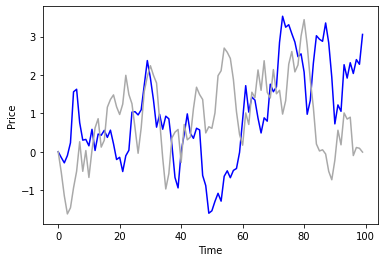

In [5]:
plt.plot(price_path, color = 'blue')
plt.plot(gene_path, color = 'darkgray')

plt.xlabel("Time")
plt.ylabel("Price")
plt.show()

## plot volatility process

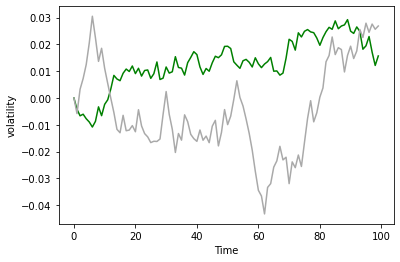

In [6]:
plt.plot(vol_path, color = 'green')
plt.plot(gene_vol_path, color = 'darkgray')
plt.xlabel("Time")
plt.ylabel("volatility")
plt.show()

# Invert log-signature

In [6]:
# Compute log-signature
order = 2
leadlag_path = leadlag(gene_path)
leadlag_price_path = leadlag(price_path)
leadlag_vol_path = leadlag(vol_path)
leadlag_price_vol_path = np.c_[leadlag_price_path, leadlag_vol_path]

logsig = tosig.stream2logsig(leadlag_path, order)
logsig_price = tosig.stream2logsig(leadlag_price_path, order)
logsig_vol = tosig.stream2logsig(leadlag_vol_path, order)

logsig_price_vol = tosig.stream2logsig(leadlag_price_vol_path, order)

## generate price process

In [25]:
n_iterations = 100
n_organisms = 1000
recovered_price_path, loss = logsig_inversion.train(logsig_price, order, n_iterations, n_organisms, 
                                              n_points, price_pip, price_n_pips)

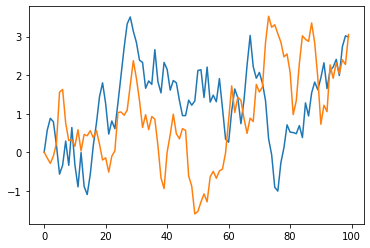

In [50]:
plt.plot(recovered_price_path)
plt.plot(price_path)
plt.show()

## Generate volatility process

In [53]:
n_iterations = 100
n_organisms = 1000
recovered_vol_path, loss = logsig_inversion.train(logsig_vol, order, n_iterations, n_organisms, 
                                              n_points, vol_pip, vol_n_pips)

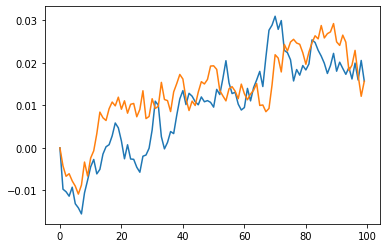

In [54]:
plt.plot(recovered_vol_path)
plt.plot(vol_path)
plt.show()

# Invert log-signature v2

In [5]:
# Compute log-signature
order = 2
leadlag_path = leadlag(gene_path)
leadlag_price_path = leadlag(price_path)
leadlag_vol_path = leadlag(vol_path)
leadlag_price_vol_path = np.c_[leadlag_price_path, leadlag_vol_path]

logsig = tosig.stream2logsig(leadlag_path, order)
logsig_price = tosig.stream2logsig(leadlag_price_path, order)
logsig_vol = tosig.stream2logsig(leadlag_vol_path, order)

logsig_price_vol = tosig.stream2logsig(leadlag_price_vol_path, order)

In [7]:
n_iterations = 100
n_organisms = 1000
recovered_price_vol_path, loss = logsig_inversion_v2.train(logsig_price_vol, order, n_iterations, n_organisms, n_points, price_pip, vol_pip, price_n_pips, vol_n_pips, top_p=0.1, mutation_prob=0.1)

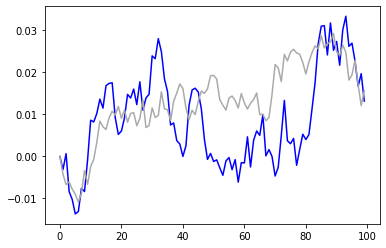

In [10]:
plt.plot(recovered_price_vol_path, color = 'blue')
plt.plot(vol_path, color = 'darkgray')
plt.show()